In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv
import seaborn as sns
import random
import os
import gc
sns.set()

In [2]:
def joinpath(img_name_list,PATH):
    imgpath=[]
    for imgname in img_name_list:
        imgpath.append(os.path.join(PATH,imgname))
    return imgpath

In [3]:
def add_binary_labels(list1,list2):
    a=[]
    b=[]
    for i in list1:
        a.append([i,0])
    for i in list2:
        b.append([i,1])
    return a,b

In [4]:
def create_dataframe(PATH):
    PATH1,PATH0 = os.listdir(PATH)
    PATH1 = os.path.join(PATH,PATH1)
    PATH0 = os.path.join(PATH,PATH0)
    
    fire_images = os.listdir(PATH1)
    none_fire_images = os.listdir(PATH0)
    fire_images = joinpath(fire_images,PATH1)
    none_fire_images = joinpath(none_fire_images,PATH0)
    nfire,fire = add_binary_labels(none_fire_images,fire_images)
    combined = nfire+fire
    random.shuffle(combined)
    data = pd.DataFrame(combined,columns=["impath","Label"])
    return(data)
PATH = "Data/Train_Data"
data = create_dataframe(PATH)
data.head()

,impath,Label
0,Data/Train_Data\Non_Fire\NF_1411.jpg,0
1,Data/Train_Data\Fire\F_497.jpg,1
2,Data/Train_Data\Non_Fire\NF_1042.jpg,0
3,Data/Train_Data\Fire\F_1547.jpg,1
4,Data/Train_Data\Non_Fire\NF_679.jpg,0


In [5]:
data.shape

(5000, 2)

In [6]:
data.head(5).values

array([['Data/Train_Data\\Non_Fire\\NF_1411.jpg', 0],
       ['Data/Train_Data\\Fire\\F_497.jpg', 1],
       ['Data/Train_Data\\Non_Fire\\NF_1042.jpg', 0],
       ['Data/Train_Data\\Fire\\F_1547.jpg', 1],
       ['Data/Train_Data\\Non_Fire\\NF_679.jpg', 0]], dtype=object)

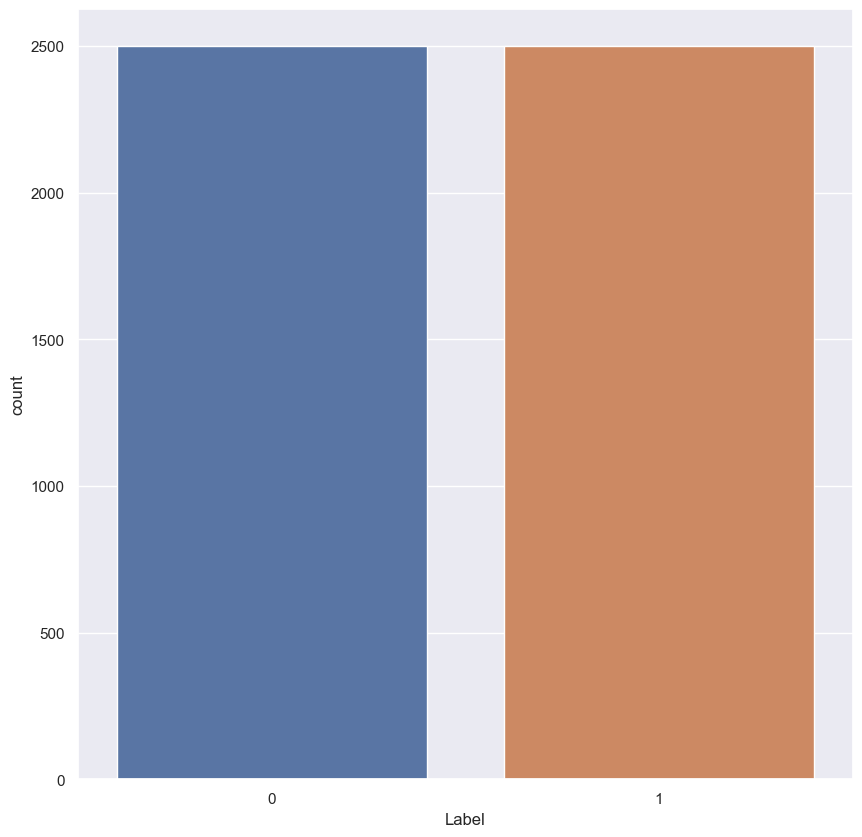

In [7]:
plt.figure(figsize = (10,10))
sns.countplot(x = "Label",data = data)
plt.show()

In [8]:
def create_input_data(dataframe):
    x = [] #Images
    y = [] #Labels
    for impath,label in dataframe.values :
        try :
            image = cv.imread(impath)
            image = cv.cvtColor(image,cv.COLOR_BGR2RGB)
            image = image/255
            image = cv.resize(image,(196,196))
            x.append(image)
            y.append(label)
        except cv.error :
            pass
    return np.array(x),np.array(y)

In [9]:
x,y = create_input_data(data)

In [10]:
del data
gc.collect()

2717

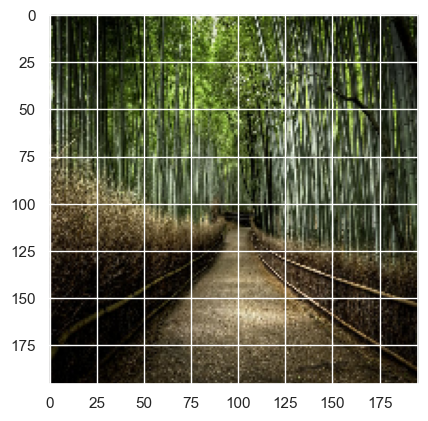

In [11]:
plt.imshow(x[2])
plt.show()

In [12]:
x.shape,y.shape

((4609, 196, 196, 3), (4609,))

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.models import Sequential

In [14]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,stratify = y)

In [15]:
del x
del y
gc.collect()

0

In [16]:
model = Sequential()
model.add(Conv2D(128,kernel_size=(2,2),input_shape = (196,196,3),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(64,kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32,kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128))
model.add(Dense(1,activation= "sigmoid"))


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 195, 195, 128)     1664      
                                                                 
 max_pooling2d (MaxPooling2  (None, 97, 97, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 48, 48, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 47, 47, 32)        8224      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 23, 23, 32)        0

In [18]:
callbacks = [EarlyStopping(monitor = 'val_loss',patience = 10,restore_best_weights=True)]
model.compile(optimizer='adam',loss = 'binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs = 10,batch_size = 32,callbacks = callbacks)

Epoch 1/10
101/101 [==============================] - 177s 2s/step - loss: 0.3754 - accuracy: 0.8590 - val_loss: 0.2842 - val_accuracy: 0.8952
Epoch 2/10
101/101 [==============================] - 148s 1s/step - loss: 0.2184 - accuracy: 0.9120 - val_loss: 0.3201 - val_accuracy: 0.8915
Epoch 3/10
101/101 [==============================] - 142s 1s/step - loss: 0.2010 - accuracy: 0.9200 - val_loss: 0.2651 - val_accuracy: 0.9277
Epoch 4/10
101/101 [==============================] - 138s 1s/step - loss: 0.1786 - accuracy: 0.9343 - val_loss: 0.2280 - val_accuracy: 0.9111
Epoch 5/10
101/101 [==============================] - 137s 1s/step - loss: 0.1582 - accuracy: 0.9380 - val_loss: 0.2530 - val_accuracy: 0.9349
Epoch 6/10
101/101 [==============================] - 136s 1s/step - loss: 0.1456 - accuracy: 0.9436 - val_loss: 0.2606 - val_accuracy: 0.9385
Epoch 7/10
101/101 [==============================] - 135s 1s/step - loss: 0.1167 - accuracy: 0.9569 - val_loss: 0.2711 - val_accuracy: 0.9262

In [19]:
PATH = "Data/Test_Data"
test_data = create_dataframe(PATH)

In [20]:
test_data['impath'][0]

'Data/Test_Data\\Fire\\F_16.jpg'

In [21]:
x,y = create_input_data(test_data)

In [22]:
x.shape,y.shape

((50, 196, 196, 3), (50,))

In [23]:
score = model.evaluate(x,y,verbose=1)

2/2 [==============================] - 0s 173ms/step - loss: 0.6115 - accuracy: 0.8200


In [24]:
score

[0.6115391254425049, 0.8199999928474426]

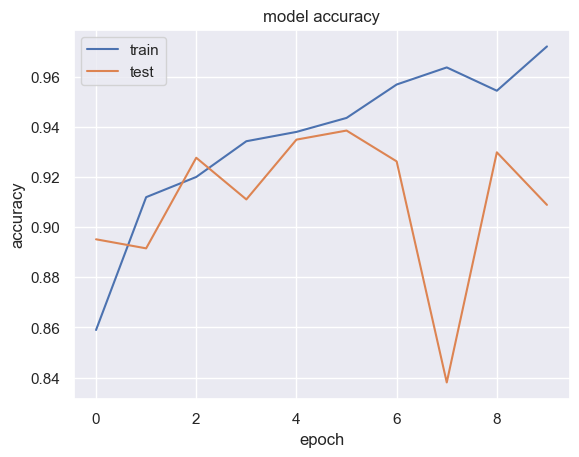

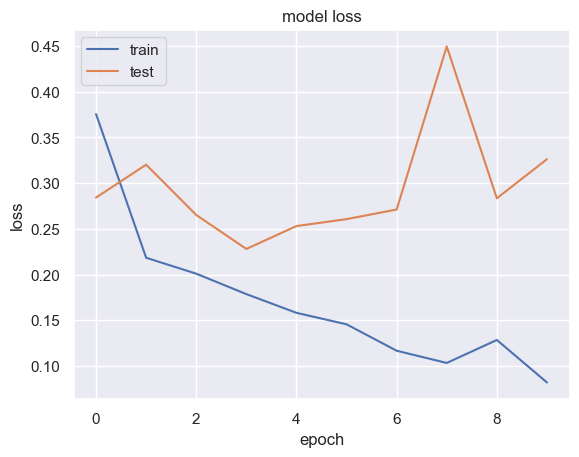

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [28]:
y_pred = model.predict(x)
y_pred = y_pred.reshape(-1)
y_pred[y_pred<0.5] = 0
y_pred[y_pred>=0.5] = 1
y_pred = y_pred.astype('int')

2/2 [==============================] - 1s 236ms/step


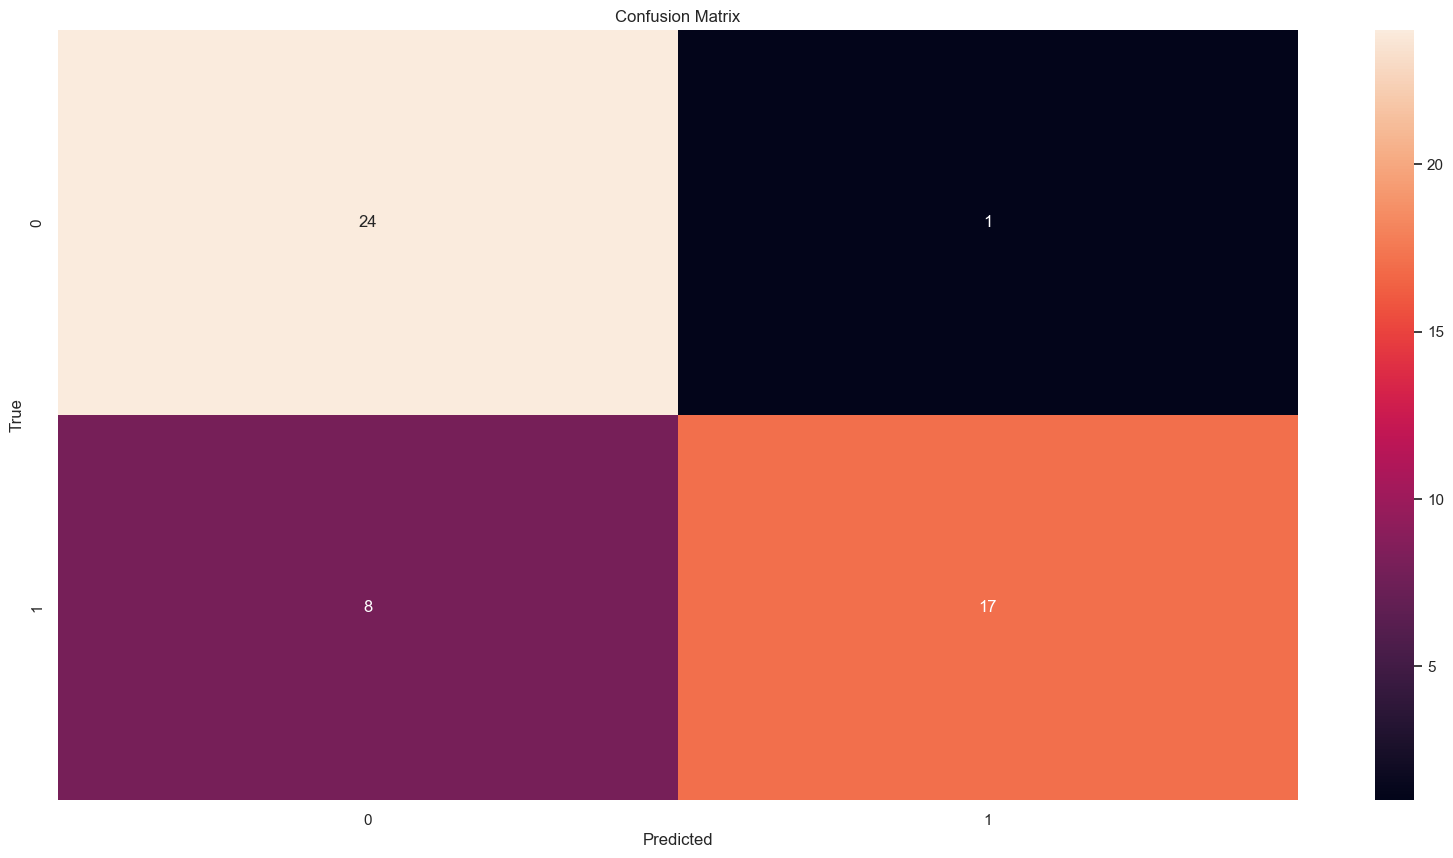

In [29]:
plt.figure(figsize = (20,10))

sns.heatmap(confusion_matrix(y,y_pred),annot = True)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

In [30]:
print(classification_report(y,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84        25
           1       0.94      0.68      0.79        25

    accuracy                           0.82        50
   macro avg       0.85      0.82      0.82        50
weighted avg       0.85      0.82      0.82        50



In [25]:
from datetime import date
from datetime import datetime
current_date = date.today()
nowtime = datetime.now()
current_time = nowtime.strftime("%H-%M")

In [26]:
model_name = f"Models/CNN_Model_on_{current_date}_at_{current_time}_with_Accuracy_of_{np.round(score[1],3)}.keras"
model.save(model_name, save_format='keras')